# TC3006B
## Deep Learning
# Script para elegir 300 imágenes al azar del bucket de s3 y obtener su meta-data

### Preparations for the script
You need to install the aws cli in order for the script to work: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

Once installed, run the command 

*aws configure*

It will ask you for some keys that are hidden for security purposes. For the region put us-east-1 and for output leave it as default "json".

And for the libraries just run 

*pip install -r requirements.txt*

If everything is configured correctly you may run now the script.

## Creación del csv

### Imports

In [81]:
import boto3
import csv
import random
from io import BytesIO
from PIL import Image, ImageStat
from concurrent.futures import ThreadPoolExecutor, as_completed

### Variables globales

In [82]:
# Configuración
BUCKET_NAME = 'caetec-vacas'  # Reemplaza con tu nombre de bucket
OUTPUT_CSV = 's3_image_metadata_advanced_with_histograms.csv'
MAX_IMAGES = 300  # Número máximo de imágenes a procesar
MAX_WORKERS = 10  # Número de hilos para procesamiento paralelo

### Creamos una lista con todos los objetos de la bucket

In [83]:
def list_all_objects(s3_client, bucket):
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket)
    all_objects = []
    for page in page_iterator:
        contents = page.get('Contents', [])
        all_objects.extend(contents)
    return all_objects

### Procesamos cada imagen obteniendo la meta-data de la misma, witdh, height, luminosity, contrast e histogramas rgb

In [84]:
def process_object(s3_client, bucket, obj):
    key = obj['Key']
    last_modified = obj['LastModified']
    size = obj['Size']
    etag = obj['ETag']
    storage_class = obj.get('StorageClass', 'STANDARD')
    owner = obj.get('Owner', {}).get('DisplayName', 'Unknown')
    content_type = obj.get('ContentType', 'Unknown')
    
    # Inicializar variables para características avanzadas
    width, height = None, None
    luminosity, contrast = None, None
    histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    try:
        # Descargar la imagen en memoria
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Asegurar que la imagen esté en RGB
        
        # Obtener dimensiones de la imagen
        width, height = image.size
        
        # Convertir la imagen a escala de grises para calcular luminosidad y contraste
        grayscale_image = image.convert('L')
        stat = ImageStat.Stat(grayscale_image)
        
        # Calcular la luminosidad (media de los valores de píxel)
        luminosity = stat.mean[0]
        
        # Calcular el contraste (desviación estándar de los valores de píxel)
        contrast = stat.stddev[0]
        
        # Calcular histogramas para cada canal
        histogram = image.histogram()
        # Histograma tiene 256 valores por canal (R, G, B)
        histogram_red = histogram[0:256]
        histogram_green = histogram[256:512]
        histogram_blue = histogram[512:768]
        
    except Exception as e:
        print(f"Error procesando {key}: {e}")
        # Asignar valores predeterminados o continuar según sea necesario
        width, height = None, None
        luminosity, contrast = None, None
        histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    # Preparar los histogramas como cadenas de texto
    histogram_red_str = ';'.join(map(str, histogram_red)) if histogram_red else ''
    histogram_green_str = ';'.join(map(str, histogram_green)) if histogram_green else ''
    histogram_blue_str = ';'.join(map(str, histogram_blue)) if histogram_blue else ''
    
    return [
        key, last_modified, size, etag, 
        storage_class, owner, content_type,
        width, height, luminosity, contrast,
        histogram_red_str, histogram_green_str, histogram_blue_str
    ]

### Creamos la funcion main y escribimos en el meta-data

In [85]:
def main():
    # Inicializar el cliente de S3
    s3 = boto3.client('s3')
    
    # Listar todos los objetos en el bucket
    print("Listando objetos en el bucket...")
    all_objects = list_all_objects(s3, BUCKET_NAME)
    total_objects = len(all_objects)
    print(f"Total de objetos en el bucket: {total_objects}")
    
    if total_objects == 0:
        print("No se encontraron objetos en el bucket.")
        return
    
    # Elegir 300 objetos al azar si hay suficientes, si no, toma todos
    sample_size = min(total_objects, MAX_IMAGES)
    sampled_objects = random.sample(all_objects, sample_size)
    print(f"Seleccionando {sample_size} objetos al azar para procesar...")
    
    # Definir los encabezados del CSV
    headers = [
        'Key', 'LastModified', 'Size', 'ETag', 
        'StorageClass', 'Owner', 'ContentType',
        'Width', 'Height', 'Luminosity', 'Contrast',
        'Histogram_Red', 'Histogram_Green', 'Histogram_Blue'
    ]
    
    # Procesar los objetos en paralelo para mejorar el rendimiento
    print("Procesando objetos y extrayendo metadata...")
    processed_data = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Enviar tareas al pool de hilos
        futures = {executor.submit(process_object, s3, BUCKET_NAME, obj): obj for obj in sampled_objects}
        for future in as_completed(futures):
            data = future.result()
            processed_data.append(data)
    
    # Escribir los datos en el CSV
    print(f"Escribiendo metadata en el archivo CSV: {OUTPUT_CSV}")
    with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Escribir encabezados
        writer.writerows(processed_data)  # Escribir filas de datos
    
    print(f"CSV creado con {sample_size} registros de metadata avanzados seleccionados al azar.")


### Corremos el programa

In [86]:
if __name__ == "__main__":
    main()

Listando objetos en el bucket...
Total de objetos en el bucket: 2189
Seleccionando 300 objetos al azar para procesar...
Procesando objetos y extrayendo metadata...
Escribiendo metadata en el archivo CSV: s3_image_metadata_advanced_with_histograms.csv
CSV creado con 300 registros de metadata avanzados seleccionados al azar.


## Creamos gráficas para visualización de la información en el csv

### Imports

In [102]:
# Importar las bibliotecas necesarias
import pandas as pd
import seaborn as sns
from PIL import Image

# Configurar estilos para las gráficas
sns.set(style="whitegrid")
%matplotlib inline


### Pasamor el csv a pandas

In [103]:
# Cargar el CSV en un DataFrame de pandas
df = pd.read_csv('s3_image_metadata_advanced_with_histograms.csv')

# Mostrar las primeras filas para verificar
df.head()


,Key,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,train/2/2024-05-19-14-15-03_jpg.rf.7a780f3227a...,2024-10-14 18:07:55+00:00,223399,"""1a91e1e11177187fe58b48cff0515d36""",STANDARD,Unknown,Unknown,1920,1080,87.143251,66.895253,0;0;0;0;0;0;0;0;2;2;5;6;17;22;68;422;1404;2677...,0;0;0;1;1;3;3;6;12;17;87;118;300;1454;5281;119...,1585;546;704;1145;1730;2649;4286;6613;14424;18...
1,test/4/2024-04-27-13-50-04_jpg.rf.cd714170c8fb...,2024-10-14 18:23:31+00:00,230204,"""ac4bdbbd30524a3f8c1caa641f7382a8""",STANDARD,Unknown,Unknown,1920,1080,98.932712,53.069916,0;0;0;1;3;2;9;9;21;40;67;113;163;239;400;649;7...,0;0;0;0;0;1;1;0;1;2;1;1;4;5;54;201;148;240;381...,12;6;6;4;5;10;14;19;24;28;52;72;162;355;512;94...
2,validation/3/2024-05-18-09-10-03_jpg.rf.1d42db...,2024-10-14 18:17:54+00:00,65813,"""7a94ef32430f2321ec312fa34c926315""",STANDARD,Unknown,Unknown,640,640,113.116941,50.849290,1;0;0;1;5;5;13;9;23;32;46;52;74;95;132;192;273...,0;0;0;0;0;0;0;0;0;0;2;1;0;6;6;10;17;33;46;90;1...,0;0;0;0;0;0;0;1;1;3;2;6;18;19;28;51;101;188;23...
3,train/2/2024-05-20-14-15-03_jpg.rf.f5d24661600...,2024-10-14 18:08:13+00:00,182714,"""86771d058e440a0a8468ef3ca4ec7ae8""",STANDARD,Unknown,Unknown,1920,1080,79.665766,63.330127,0;0;0;0;0;0;0;1;2;6;34;320;844;2278;4231;4249;...,0;0;0;1;5;6;24;28;99;251;910;2594;7169;15873;1...,4713;2003;3105;4688;6145;7084;11969;20912;2681...
4,test/1/2024-04-28-00-30-03_jpg.rf.46abc5fbe54a...,2024-10-14 18:27:40+00:00,131196,"""ef341ee7bd251b5cb4203de3635a72aa""",STANDARD,Unknown,Unknown,1920,1080,11.529639,13.004799,44708;97985;109414;101581;84924;81433;76098;69...,163059;222261;193087;155633;133964;120252;1074...,541225;304888;228637;196998;169942;142445;1143...


### Visualizamos csv

In [104]:
df

,Key,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,train/2/2024-05-19-14-15-03_jpg.rf.7a780f3227a...,2024-10-14 18:07:55+00:00,223399,"""1a91e1e11177187fe58b48cff0515d36""",STANDARD,Unknown,Unknown,1920,1080,87.143251,66.895253,0;0;0;0;0;0;0;0;2;2;5;6;17;22;68;422;1404;2677...,0;0;0;1;1;3;3;6;12;17;87;118;300;1454;5281;119...,1585;546;704;1145;1730;2649;4286;6613;14424;18...
1,test/4/2024-04-27-13-50-04_jpg.rf.cd714170c8fb...,2024-10-14 18:23:31+00:00,230204,"""ac4bdbbd30524a3f8c1caa641f7382a8""",STANDARD,Unknown,Unknown,1920,1080,98.932712,53.069916,0;0;0;1;3;2;9;9;21;40;67;113;163;239;400;649;7...,0;0;0;0;0;1;1;0;1;2;1;1;4;5;54;201;148;240;381...,12;6;6;4;5;10;14;19;24;28;52;72;162;355;512;94...
2,validation/3/2024-05-18-09-10-03_jpg.rf.1d42db...,2024-10-14 18:17:54+00:00,65813,"""7a94ef32430f2321ec312fa34c926315""",STANDARD,Unknown,Unknown,640,640,113.116941,50.849290,1;0;0;1;5;5;13;9;23;32;46;52;74;95;132;192;273...,0;0;0;0;0;0;0;0;0;0;2;1;0;6;6;10;17;33;46;90;1...,0;0;0;0;0;0;0;1;1;3;2;6;18;19;28;51;101;188;23...
3,train/2/2024-05-20-14-15-03_jpg.rf.f5d24661600...,2024-10-14 18:08:13+00:00,182714,"""86771d058e440a0a8468ef3ca4ec7ae8""",STANDARD,Unknown,Unknown,1920,1080,79.665766,63.330127,0;0;0;0;0;0;0;1;2;6;34;320;844;2278;4231;4249;...,0;0;0;1;5;6;24;28;99;251;910;2594;7169;15873;1...,4713;2003;3105;4688;6145;7084;11969;20912;2681...
4,test/1/2024-04-28-00-30-03_jpg.rf.46abc5fbe54a...,2024-10-14 18:27:40+00:00,131196,"""ef341ee7bd251b5cb4203de3635a72aa""",STANDARD,Unknown,Unknown,1920,1080,11.529639,13.004799,44708;97985;109414;101581;84924;81433;76098;69...,163059;222261;193087;155633;133964;120252;1074...,541225;304888;228637;196998;169942;142445;1143...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,validation/4/2024-05-18-13-30-03_jpg.rf.09460d...,2024-10-14 18:17:07+00:00,56294,"""f730d111544bca49cb1771fa89c79584""",STANDARD,Unknown,Unknown,640,640,89.524285,61.976788,0;0;2;2;5;8;10;16;22;30;54;76;95;151;310;666;9...,0;0;0;0;0;1;1;1;0;2;5;17;59;147;642;750;654;64...,17;4;6;9;15;33;65;115;170;422;647;1086;855;125...
296,train/5/2024-05-21-02-00-03_jpg.rf.1c4b4f74fb3...,2024-10-14 18:14:07+00:00,123112,"""a7f6247e3c45d7b50de5fb8855148ee2""",STANDARD,Unknown,Unknown,1920,1080,10.943487,16.337681,48313;185680;226812;170081;114899;91123;76494;...,221412;333036;250178;170431;123267;98677;81615...,556731;395201;240449;180923;142533;111758;8726...
297,train/4/2024-05-21-01-30-03_jpg.rf.31557eede14...,2024-10-14 18:12:28+00:00,128171,"""119f047b4893df964131e13c2f764949""",STANDARD,Unknown,Unknown,1920,1080,14.222785,20.803004,222690;279190;163354;113506;81510;63019;53555;...,285488;343264;197151;124615;89892;73534;62780;...,623892;391058;193045;139210;109157;85336;65183...
298,test/1/2024-04-28-01-55-03_jpg.rf.81e7edaac069...,2024-10-14 18:27:41+00:00,142231,"""1d683e57423cb7f1f6a08c81039945d5""",STANDARD,Unknown,Unknown,1920,1080,16.367732,12.850561,1257;5455;15510;16753;23648;35157;40646;42753;...,79568;90903;107623;113014;112070;105250;96068;...,362984;207852;225710;224845;210304;184049;1542...


### Convertimos la cadena de histogramas en strings a int

In [105]:
# Definir una función para convertir la cadena de histograma en una lista de enteros
def histogram_str_to_list(hist_str):
    if pd.isna(hist_str) or hist_str == '':
        return [0]*256
    return list(map(int, hist_str.split(';')))

# Aplicar la función a las columnas de histogramas
df['Histogram_Red'] = df['Histogram_Red'].apply(histogram_str_to_list)
df['Histogram_Green'] = df['Histogram_Green'].apply(histogram_str_to_list)
df['Histogram_Blue'] = df['Histogram_Blue'].apply(histogram_str_to_list)

# Verificar la conversión
df[['Histogram_Red', 'Histogram_Green', 'Histogram_Blue']].head()


,Histogram_Red,Histogram_Green,Histogram_Blue
0,"[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 5, 6, 17, 22, 6...","[0, 0, 0, 1, 1, 3, 3, 6, 12, 17, 87, 118, 300,...","[1585, 546, 704, 1145, 1730, 2649, 4286, 6613,..."
1,"[0, 0, 0, 1, 3, 2, 9, 9, 21, 40, 67, 113, 163,...","[0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 4, 5, 54,...","[12, 6, 6, 4, 5, 10, 14, 19, 24, 28, 52, 72, 1..."
2,"[1, 0, 0, 1, 5, 5, 13, 9, 23, 32, 46, 52, 74, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 2, 6, 18, 19, 2..."
3,"[0, 0, 0, 0, 0, 0, 0, 1, 2, 6, 34, 320, 844, 2...","[0, 0, 0, 1, 5, 6, 24, 28, 99, 251, 910, 2594,...","[4713, 2003, 3105, 4688, 6145, 7084, 11969, 20..."
4,"[44708, 97985, 109414, 101581, 84924, 81433, 7...","[163059, 222261, 193087, 155633, 133964, 12025...","[541225, 304888, 228637, 196998, 169942, 14244..."


### Seleccionamos una imagen al azar y ploteamos los histogramas con la intensidad de rgb

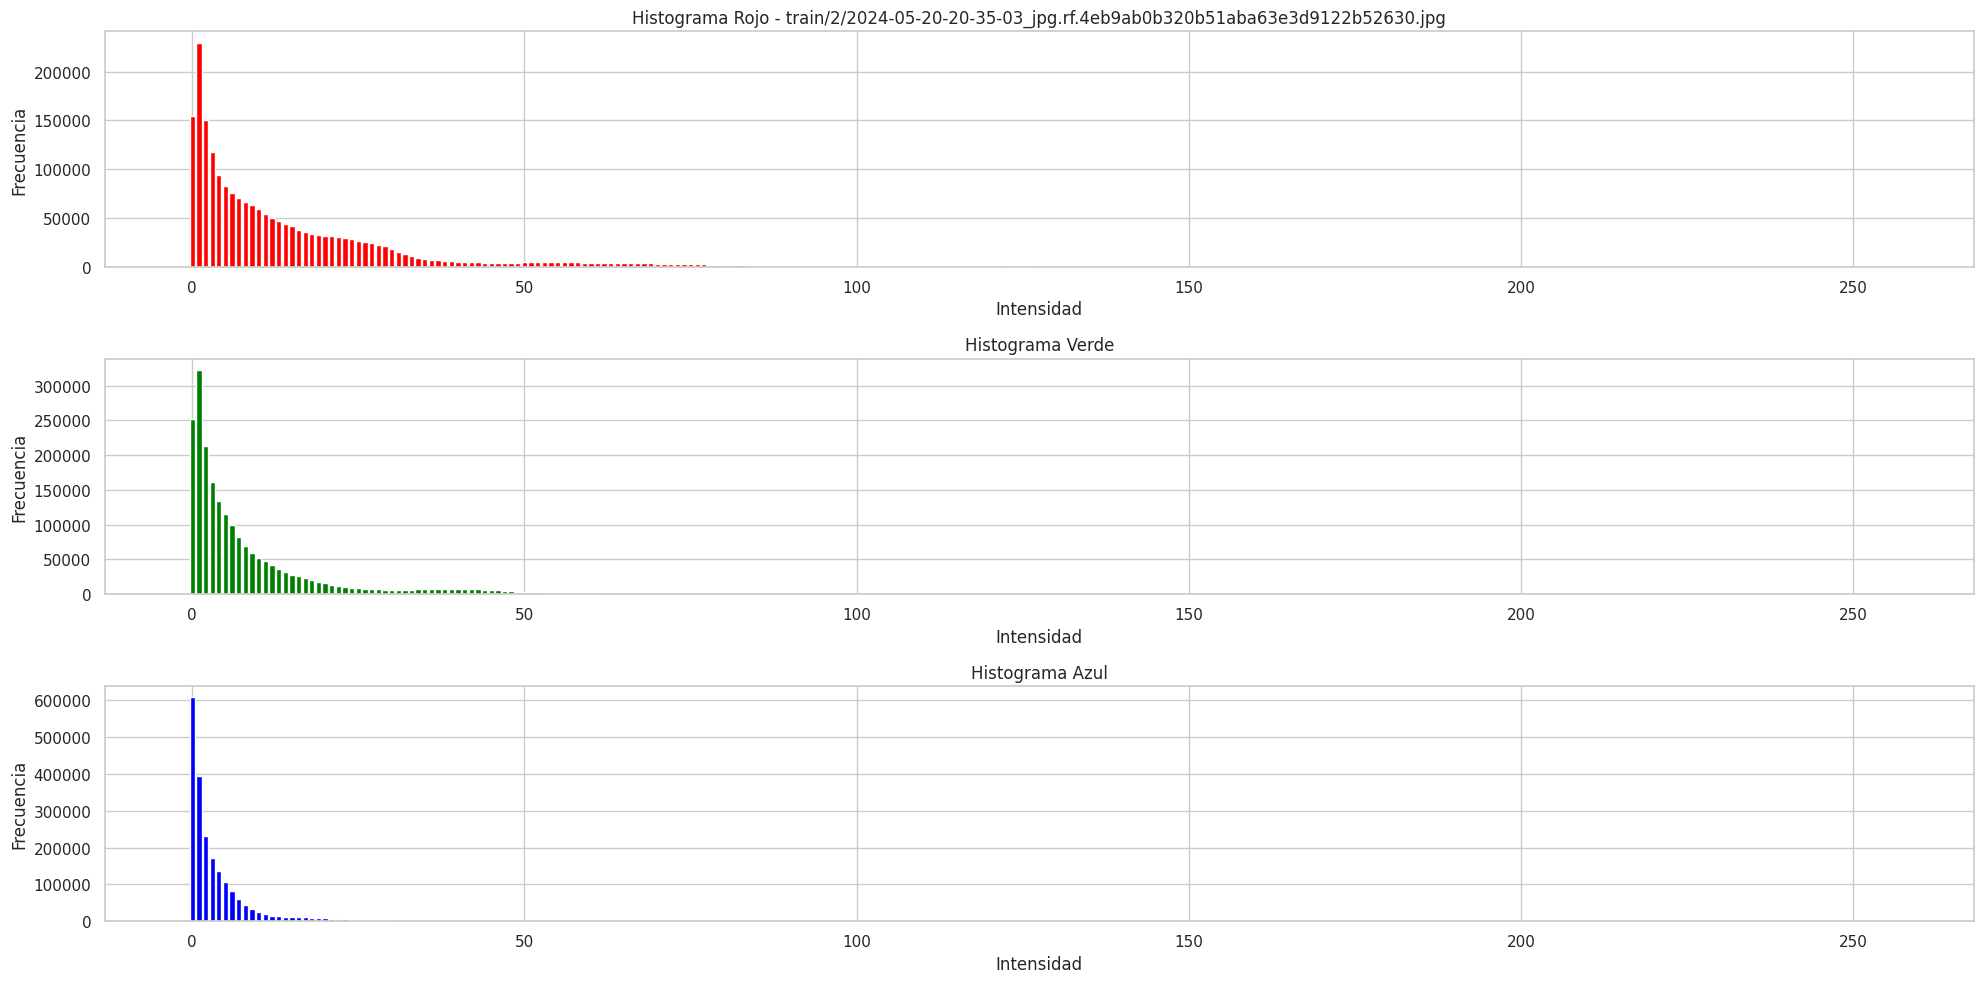

In [106]:
import random
import matplotlib.pyplot as plt

# Seleccionar una imagen al azar
random_index = random.randint(0, len(df)-1)
image_row = df.iloc[random_index]

# Extraer los histogramas
hist_red = image_row['Histogram_Red']
hist_green = image_row['Histogram_Green']
hist_blue = image_row['Histogram_Blue']

# Crear los histogramas
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)  # 3 filas, 1 columna, primer subplot
plt.bar(range(256), hist_red, color='red')
plt.title(f"Histograma Rojo - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 2)  # 3 filas, 1 columna, segundo subplot
plt.bar(range(256), hist_green, color='green')
plt.title("Histograma Verde")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 3)  # 3 filas, 1 columna, tercer subplot
plt.bar(range(256), hist_blue, color='blue')
plt.title("Histograma Azul")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Sobreponemos los 3 histogramas

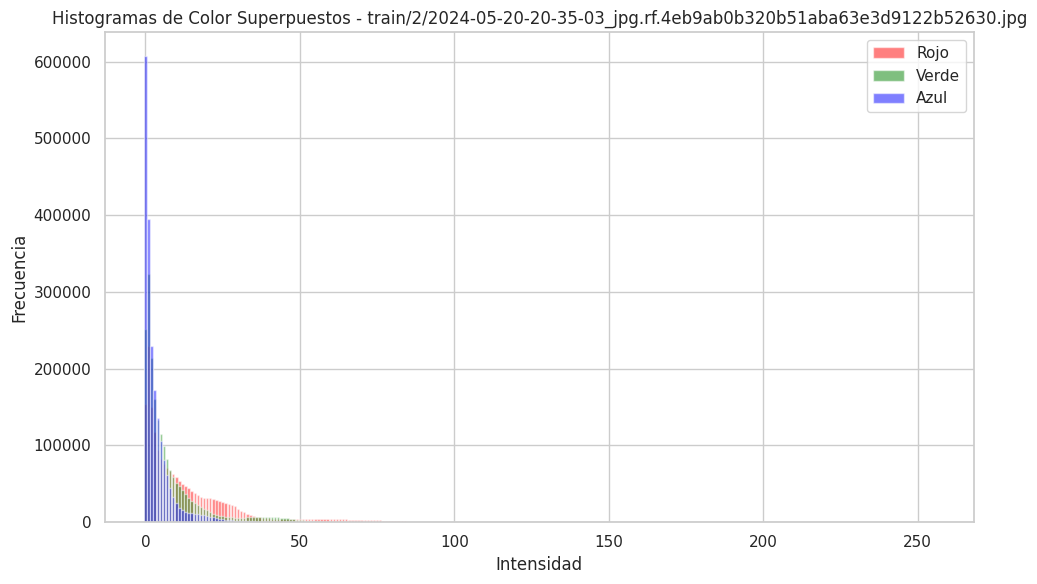

In [107]:
import matplotlib.pyplot as plt

# Crear una sola gráfica con los tres histogramas superpuestos
plt.figure(figsize=(10, 6))

plt.bar(range(256), hist_red, color='red', alpha=0.5, label='Rojo')
plt.bar(range(256), hist_green, color='green', alpha=0.5, label='Verde')
plt.bar(range(256), hist_blue, color='blue', alpha=0.5, label='Azul')

plt.title(f"Histogramas de Color Superpuestos - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()


### Creamos el histograma promedio de todo el dataset 

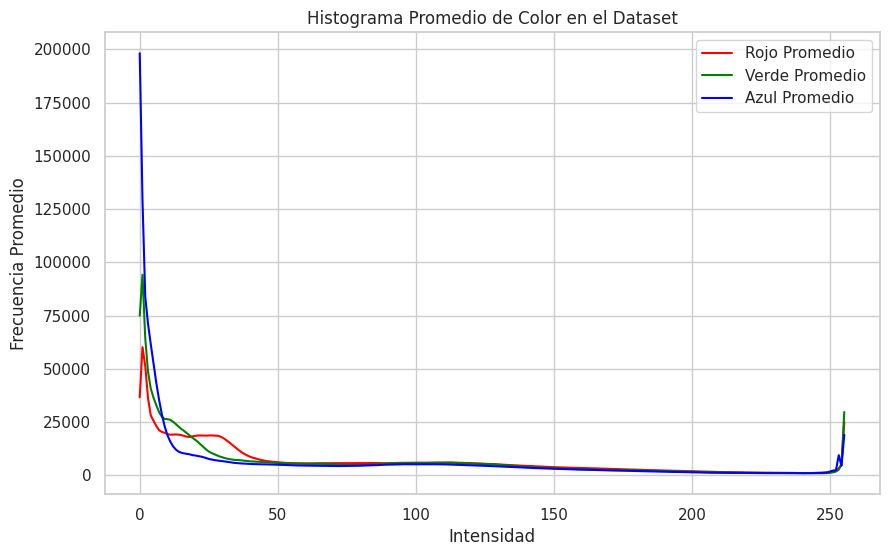

In [108]:
import numpy as np

# Inicializar arrays para acumular los histogramas
accum_hist_red = np.zeros(256)
accum_hist_green = np.zeros(256)
accum_hist_blue = np.zeros(256)

# Acumular los histogramas de todas las imágenes
for idx, row in df.iterrows():
    accum_hist_red += np.array(row['Histogram_Red'])
    accum_hist_green += np.array(row['Histogram_Green'])
    accum_hist_blue += np.array(row['Histogram_Blue'])

# Calcular los histogramas promedio
num_images = len(df)
avg_hist_red = accum_hist_red / num_images
avg_hist_green = accum_hist_green / num_images
avg_hist_blue = accum_hist_blue / num_images

# Graficar los histogramas promedio
plt.figure(figsize=(10, 6))
plt.plot(range(256), avg_hist_red, color='red', label='Rojo Promedio')
plt.plot(range(256), avg_hist_green, color='green', label='Verde Promedio')
plt.plot(range(256), avg_hist_blue, color='blue', label='Azul Promedio')
plt.title('Histograma Promedio de Color en el Dataset')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia Promedio')
plt.legend()
plt.show()


### Graficamos la luminosidad y el contraste de las imágenes en el dataset

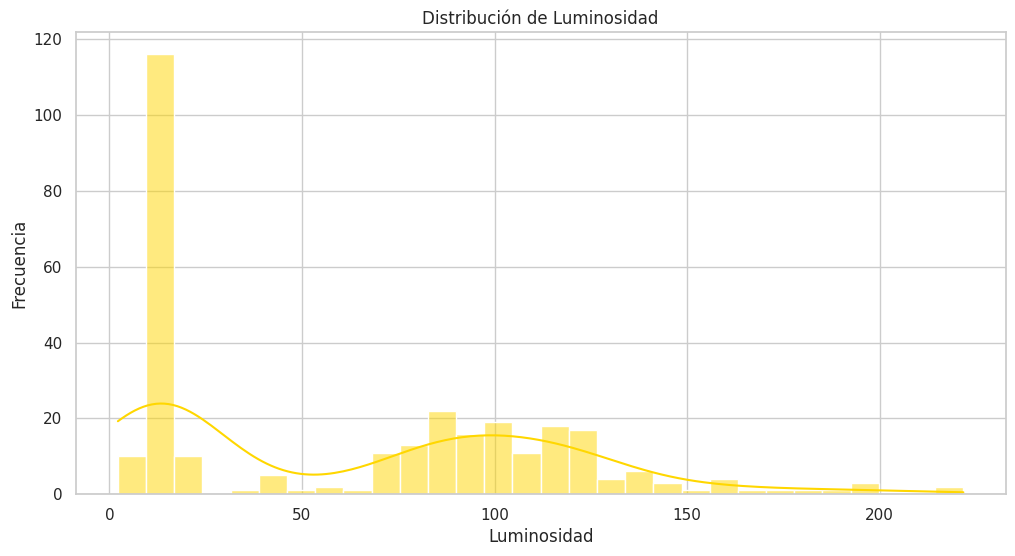

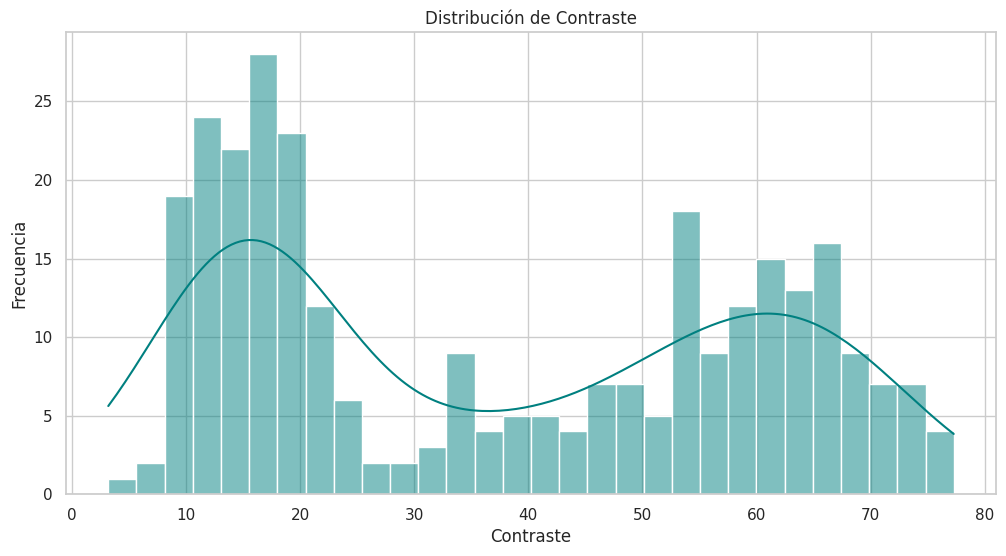

In [109]:
# Graficar la distribución de Luminosidad
plt.figure(figsize=(12, 6))
sns.histplot(df['Luminosity'], bins=30, kde=True, color='gold')
plt.title('Distribución de Luminosidad')
plt.xlabel('Luminosidad')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de Contraste
plt.figure(figsize=(12, 6))
sns.histplot(df['Contrast'], bins=30, kde=True, color='teal')
plt.title('Distribución de Contraste')
plt.xlabel('Contraste')
plt.ylabel('Frecuencia')
plt.show()


### Vemos el promedio de luminosidad en el dataset

In [110]:
print(df['Luminosity'].describe())


count    300.000000
mean      63.576996
std       51.926407
min        2.190472
25%       13.420341
50%       70.902317
75%      104.079127
max      221.761518
Name: Luminosity, dtype: float64


### Dividimos el dataset en cuantiles para tener 25%, 50% y 75%

In [111]:
# Calcular los cuartiles de la luminosidad
q1 = df['Luminosity'].quantile(0.25)
q3 = df['Luminosity'].quantile(0.75)
median_luminosity = df['Luminosity'].median()

print(f"Q1 (25%): {q1}")
print(f"Mediana (50%): {median_luminosity}")
print(f"Q3 (75%): {q3}")


Q1 (25%): 13.420341073495369
Mediana (50%): 70.90231746720679
Q3 (75%): 104.07912651909722


### Filtramos las imágenes según la cateroría de luminosidad, q1, q2 y q3

In [112]:
# Definir los rangos de luminosidad
luminosity_low_max = q1
luminosity_average_min = q1
luminosity_average_max = q3
luminosity_high_min = q3

# Filtrar imágenes por categoría
low_luminosity_df = df[df['Luminosity'] <= luminosity_low_max]
average_luminosity_df = df[(df['Luminosity'] > luminosity_average_min) & (df['Luminosity'] <= luminosity_average_max)]
high_luminosity_df = df[df['Luminosity'] > luminosity_high_min]

# Verificar el número de imágenes en cada categoría
print(f"Número de imágenes con baja luminosidad: {len(low_luminosity_df)}")
print(f"Número de imágenes con luminosidad promedio: {len(average_luminosity_df)}")
print(f"Número de imágenes con alta luminosidad: {len(high_luminosity_df)}")


Número de imágenes con baja luminosidad: 75
Número de imágenes con luminosidad promedio: 150
Número de imágenes con alta luminosidad: 75


### Función para descargar una imagen del s3 según la key

In [113]:
def download_image_from_s3(s3_client, bucket, key):
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Convertir a RGB si es necesario
        return image
    except Exception as e:
        print(f"Error al descargar o procesar la imagen {key}: {e}")
        return None


### Función para descargar 3 imágenes del s3 según las 3 categorías

In [114]:
# Función para seleccionar una imagen al azar de un DataFrame
def select_random_image(df_category):
    if df_category.empty:
        print("No hay imágenes en esta categoría.")
        return None
    return df_category.sample(n=1).iloc[0]

# Seleccionar una imagen de cada categoría
image_low = select_random_image(low_luminosity_df)
image_average = select_random_image(average_luminosity_df)
image_high = select_random_image(high_luminosity_df)


### Descargamos las 3 imágenes

In [115]:
# Descargar las imágenes
image_low_pil = download_image_from_s3(s3, BUCKET_NAME, image_low['Key']) if image_low is not None else None
image_average_pil = download_image_from_s3(s3, BUCKET_NAME, image_average['Key']) if image_average is not None else None
image_high_pil = download_image_from_s3(s3, BUCKET_NAME, image_high['Key']) if image_high is not None else None


### Mostramos las 3 imágenes, una para cada nivel de luminosidad

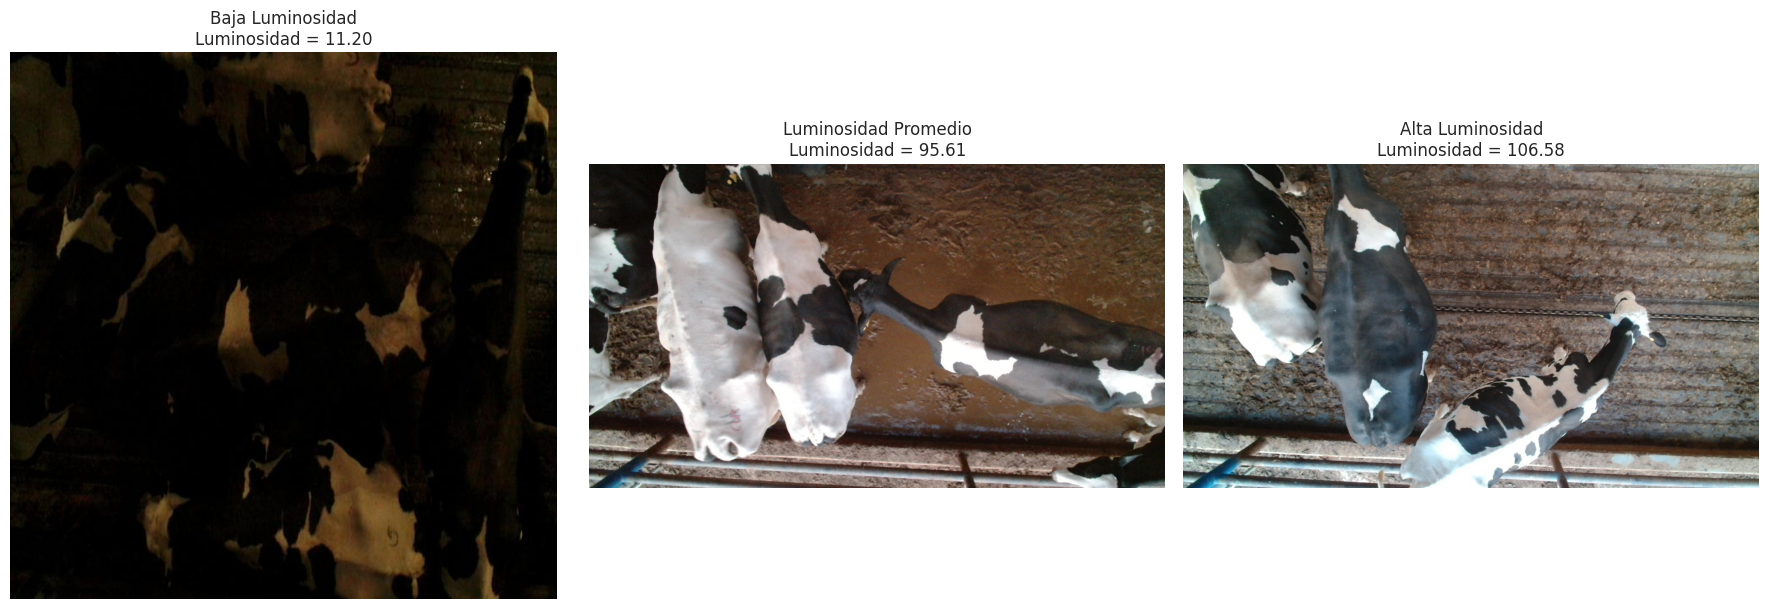

In [116]:
# Crear una figura con 3 subplots
plt.figure(figsize=(18, 6))

# Imagen de baja luminosidad
plt.subplot(1, 3, 1)
if image_low_pil:
    plt.imshow(image_low_pil)
    plt.title(f'Baja Luminosidad\nLuminosidad = {image_low["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de luminosidad promedio
plt.subplot(1, 3, 2)
if image_average_pil:
    plt.imshow(image_average_pil)
    plt.title(f'Luminosidad Promedio\nLuminosidad = {image_average["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de alta luminosidad
plt.subplot(1, 3, 3)
if image_high_pil:
    plt.imshow(image_high_pil)
    plt.title(f'Alta Luminosidad\nLuminosidad = {image_high["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

plt.tight_layout()
plt.show()